### 0.Imports

In [ ]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import  RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
import category_encoders as ce


# modificar el path
# -----------------------------------------------------------------------
import sys
import os
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.model_evaluation_support as mes
import src.data_visualization_support as dvs


# Registro de modelos
# -----------------------------------------------------------------------
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import logging
# Set MLflow logging level to ERROR
logging.getLogger("mlflow").setLevel(logging.ERROR)


# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# handle warnings
# -----------------------------------------------------------------------
import warnings


seed = 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Functions under construction

# 1. Introduction - Madrid rental prices - Modelling

The approach for this model evaluation notebook is to define the conditions for each particular experiment, derived from the exploratory data analysis and the preprocessing steps pondered in the previous notebooks.

Experiment tracking will be carried out with MLFlow.

In the Model Evaluation section, all experiments will be laid out. The first section of each experiment, will be the definition of its conditions. Subsequently, data preparation (or cleaning), data preprocessing, feature engineering and models to evaluate code will be defined, to give way to the run experiment section. 

Finally, an analysis of the experiment will be carried out.

### 1.1 Data import

First, let's import the data necessary for the experiment.

In [143]:
pd.set_option("display.max_columns",40)
rent_df = pd.read_csv("../datos/explored/rent_df_explored_v1.csv", index_col=0).reset_index(drop=True)
rent_df.head()

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
0,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,False,False,True,False,3.0,Madrid
1,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,False,False,0.0,Other
2,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,False,False,2.0,Other
3,11,590.0,flat,70.0,True,3 or more,2,56596,8.428571,False,False,False,False,False,NaN,Other
4,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,True,True,False,False,NaN,Madrid


## 2. Set experiment tracking with MLflow

Set MLFlow tracking folder, activate autolog and set an experiment name for tracking.

In [3]:
mlflow.set_tracking_uri("../model_tracking")  # Local directory
mlflow.set_experiment("rent_price_madrid")
mlflow.autolog()

# 3. Model evaluation

## 3.1 Experiment 1 - target: priceByArea - predictors: numerical variables

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: Linear Regression, Lasso Regression, Huber Regressor, Decision Tree Regressor, Random Forest Regressor.
- Hyperparameter tuning: True
- Features: Numerical features - ["numPhotos","reciprocal_size","distance","bathrooms"]. Select best combination through RFE.
- Preprocessing.
    - Missing: False
    - Outliers: False
    - Encoding: False
    - Scaling: Robust Scaler.
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.1.1 Data preparation

Data preparation steps are the same from the exploration notebook, and as such the cleaned data comes from there. [TO BE CHANGED BY A SCRIPT WITH THE STEPS]

### 3.1.2 Data preprocessing

Definition of the preprocessing pipeline, just a robust scaler is used, to preserve outliers information.

In [ ]:
scaler = RobustScaler()

preprocessing_pipeline = Pipeline([
        ('scaler', scaler)
    ])

### 3.1.3 Feature engineering

To approximate the relationship between priceByArea and size variables to linearity, the reciprocal of size can be calculated as:

In [13]:
rent_df["reciprocal_size"] = 1 / rent_df["size"]

### 3.1.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [17]:
models = {
    'LinearRegression': (
        LinearRegression(), 
        {}
    ),

    'HuberRegressor': (
        HuberRegressor(),
        {
            'regressor__alpha': [1e-4, 1e-2, 0.1, 1, 10],
            'regressor__epsilon': [1.2, 1.5, 2.0, 2.5],
            'regressor__max_iter': [100, 300, 500, 700, 1000]
        }
    ),

    'LassoRegression': (
        Lasso(max_iter=10000),
        {
            'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
    ),

    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150, 200],
            'regressor__max_depth': [10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 5, 10],
            'regressor__bootstrap': [True, False]
        }
    ),

    'DecisionTree': (
        DecisionTreeRegressor(),
        {
            'regressor__max_depth': [5, 10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 3, 5, 10],
            'regressor__max_leaf_nodes': [15, 20, 30, 40]
        }
    )
}


### 3.1.5 Run experiment

Define X and y. Price must be excluded of course, as well as the original size feature. 

Perform train and test split. Define a bootstrapped repeated kfold cross validation to improve metric robustness. Optimize for minimal root_mean_squared error.

In [ ]:
X = rent_df[["numPhotos","reciprocal_size","distance","bathrooms"]] 
y = rent_df["priceByArea"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

Perform feature selection from the 4 numerical features.

In [19]:
selection_params = {key.replace("regressor__",""): value for key, value in models["DecisionTree"][1].items()}

selected_features = mes.select_best_features(X_train, y_train, score=score, cross_val=cross_val, 
                                         model="decision_tree", params=selection_params, method="grid")

X_train = X_train[selected_features]
X_test = X_test[selected_features]

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")
best_model

Selected Features with RFECV: Index(['reciprocal_size', 'distance'], dtype='object')


{'model_name': 'LinearRegression',
 'pipeline': Pipeline(steps=[('regressor', LinearRegression())]),
 'params': {},
 'score': np.float64(-1.0197630345971767)}

The best model selected was Linear Regression, just using the 2 columns reciprocal_size and distance.

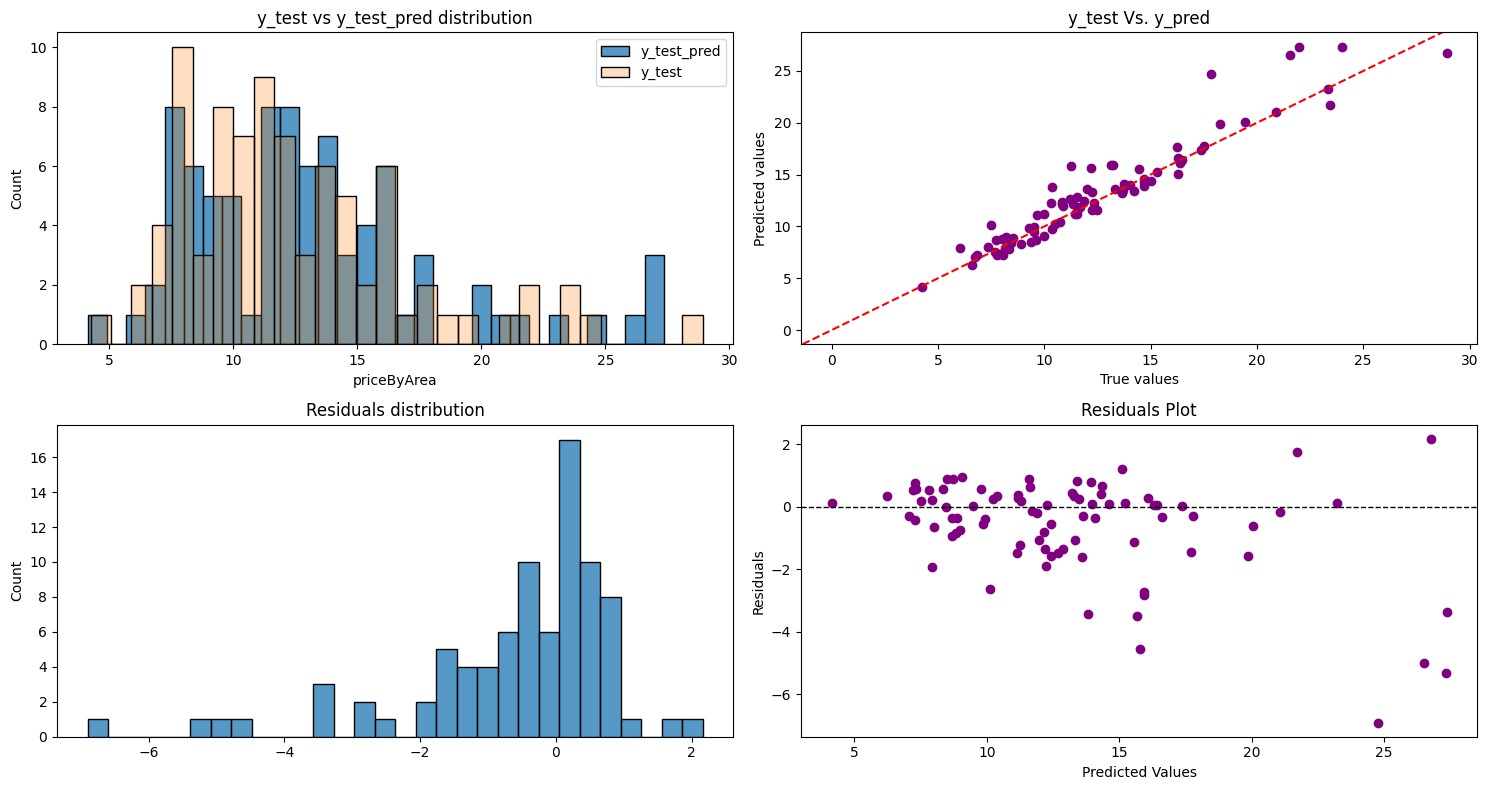

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.964601,0.710244,1.000751,28.270861,1.000375
test,0.870515,1.050784,2.727953,21.067777,1.651652


In [21]:
tag = ("pipeline_preprocessing", "RobustScaler")

X_train = X_train[selected_features]
X_test = X_test[selected_features]

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - priceByArea - numerical", model, X_train, y_train, X_test, y_test, tag=tag)

There is indeed quite some overfitting, and results look promising as RMSE is low. However, the model tends to over predict a lot and RMSE cannot yet be trusted as this variance has been reduced with respect to the original price. To properly check performance, it is necessary to transform back to price.

In [27]:
# filtering the df to compare true values with predicted
y_test_df = rent_df.iloc[y_test.index]

# predict priceByArea and calculate price
y_test_df["priceByArea_pred"] = model.predict(X_test)

y_test_df["price_pred"] = y_test_df["priceByArea_pred"] * y_test_df["size"]

# visually compare the values
y_test_df[["price","size","priceByArea","priceByArea_pred","price_pred"]].head(10)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_4996\1549544539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_df["priceByArea_pred"] = model.predict(X_test)
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4996\1549544539.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_df["price_pred"] = y_test_df["priceByArea_pred"] * y_test_df["size"]


,price,size,priceByArea,priceByArea_pred,price_pred
46,500.0,28.0,17.857143,24.753784,693.105945
163,740.0,60.0,12.333333,12.278657,736.719449
57,650.0,65.0,10.000000,11.232101,730.086552
25,750.0,60.0,12.500000,11.600770,696.046195
113,750.0,50.0,15.000000,14.337128,716.856415
198,692.0,83.0,8.337349,8.689456,721.224820
108,650.0,62.0,10.483871,10.242119,635.011393
63,750.0,95.0,7.894737,7.335507,696.873189
249,525.0,40.0,13.125000,15.932774,637.310949
326,720.0,69.6,10.344828,9.789865,681.374624


As previewed in the exploration of resduals for priceByArea, this model cannot account for the variance in the price just with these 2 features and as we can see below the RMSE had been undervalued when it is actually higher. 

In [32]:
print(f"RMSE for price is {root_mean_squared_error(y_test_df['price'],y_test_df['price_pred'])}")

RMSE for price is 68.84724854145827


Plot the distributions, predictions Vs. the true values and the distribution of residuals for the calculated price from predictions.

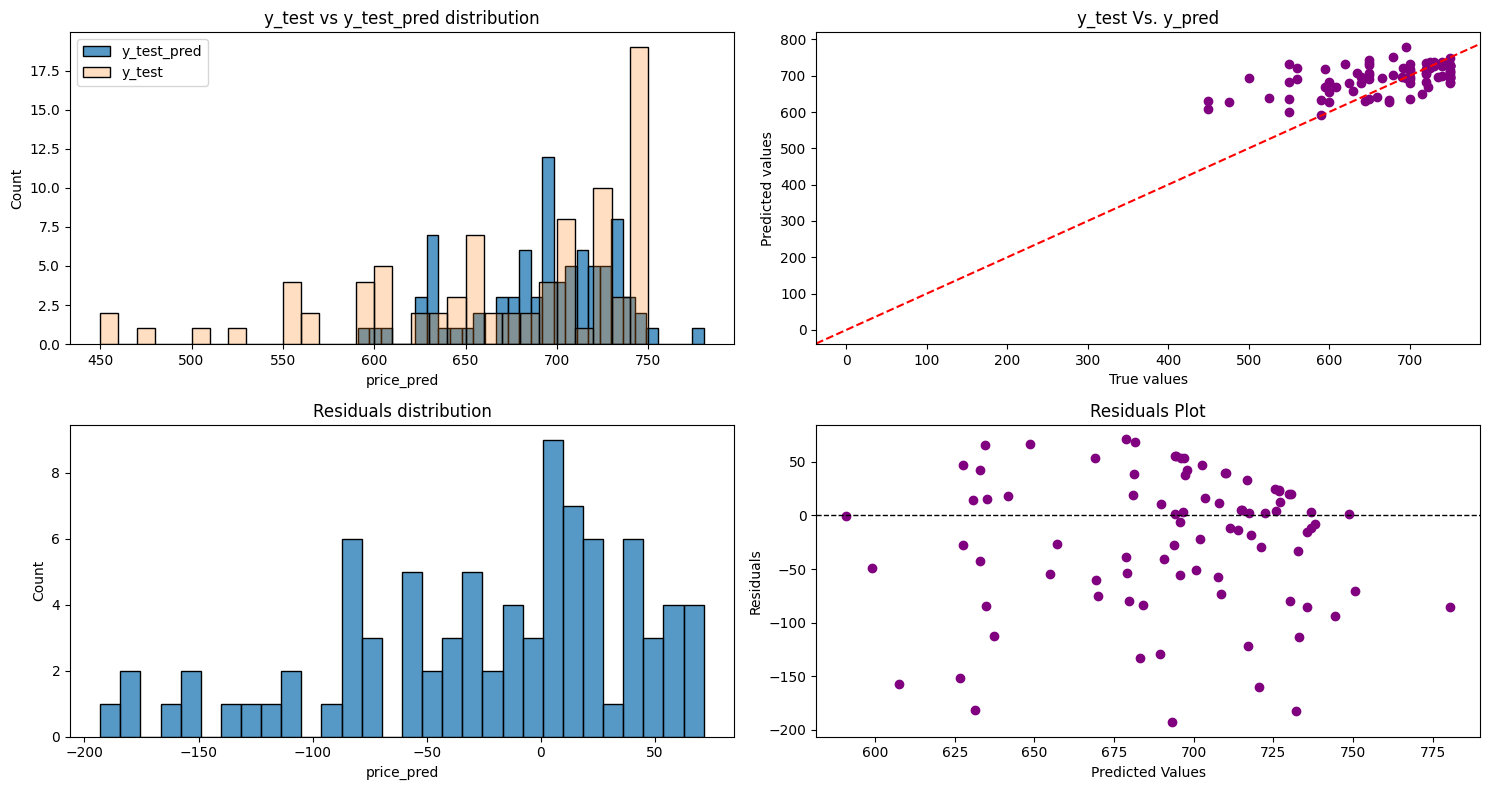

In [33]:
mes.plot_prediction_residuals(y_test_df["price"],y_test_df["price_pred"])

As said above, the main problem is that predictions center around 700 euros and therefore it does not account for the variability of lowerend values. Anyhow, it does not properly fit to other variations in price. It is worth comparing it two more experiments:
- Same selected features, no robust scaler for the selected non linear models plus gradient boosting
- Same selected features, powertransform on distance.

## 3.2 Experiment 2 

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: Decision Tree Regressor, Random Forest Regressor, GradientBoosting
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance"].
- Preprocessing.
    - Missing: False
    - Outliers: False
    - Encoding: False
    - Scaling: False.
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.2.1 Data preparation

Data preparation steps are the same from the exploration notebook, and as such the cleaned data comes from there. [TO BE CHANGED BY A SCRIPT WITH THE STEPS]

### 3.2.2 Data preprocessing

Definition of the preprocessing pipeline, just a robust scaler is used, to preserve outliers information.

In [62]:
preprocessing_pipeline = Pipeline([]) # empty instead of None, to not have to change the architecture

### 3.2.3 Feature engineering

To approximate the relationship between priceByArea and size variables to linearity.

In [63]:
rent_df["reciprocal_size"] = 1 / rent_df["size"]

### 3.2.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [64]:
models = {

    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150, 200],
            'regressor__max_depth': [10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 5, 10],
            'regressor__bootstrap': [True, False]
        }
    ),

    'DecisionTree': (
        DecisionTreeRegressor(),
        {
            'regressor__max_depth': [5, 10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 3, 5, 10],
            'regressor__max_leaf_nodes': [15, 20, 30, 40]
        }
    ),
    
    'GradientBoosting': (
        GradientBoostingRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [5, 7, 10,None],
            'regressor__min_samples_split': [5, 10, None],
            'regressor__min_samples_leaf': [5, 10, 15],
            'regressor__subsample': [0.6, 0.8, 1.0],
        }
    )
}


### 3.2.5 Run experiment

Define X and y. Price must be excluded of course, as well as the original size feature. 

Perform train and test split. Define a bootstrapped repeated kfold cross validation to improve metric robustness. Optimize for minimal root_mean_squared error.

In [65]:
X = rent_df[["reciprocal_size","distance"]] 
y = rent_df["priceByArea"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")
best_model

{'model_name': 'RandomForest',
 'pipeline': Pipeline(steps=[('regressor',
                  RandomForestRegressor(max_depth=15, min_samples_split=5,
                                        n_estimators=150))]),
 'params': {'regressor__bootstrap': True,
  'regressor__max_depth': 15,
  'regressor__min_samples_leaf': 1,
  'regressor__min_samples_split': 5,
  'regressor__n_estimators': 150},
 'score': np.float64(-1.1022854716082786)}

The best model selected was RandomForest. Let's inspect its residuals, although its RMSE is already not looking too good.

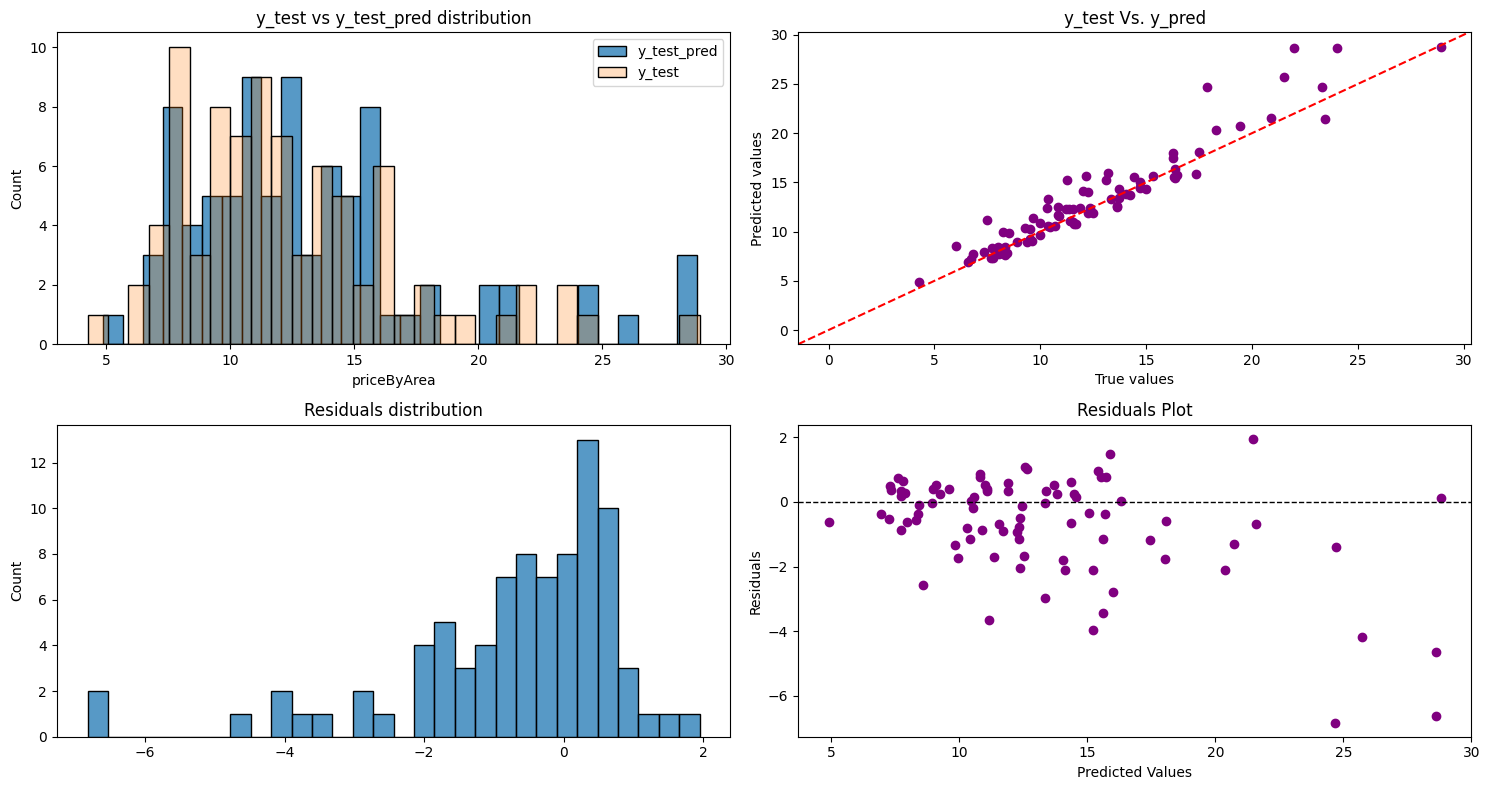

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.987872,0.401371,0.342856,28.270861,0.585539
test,0.854521,1.160427,3.064914,21.067777,1.750690


In [66]:
tag = ("pipeline_preprocessing", "-")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - priceByArea | non-linear - numerical - ", model, X_train, y_train, X_test, y_test, tag=tag)

There is even more overfitting than there was with linear regression. Lower RMSE for the training set and higher for the test set.

In [70]:
# filtering the df to compare true values with predicted
y_test_df = rent_df.iloc[y_test.index]

# predict priceByArea and calculate price
y_test_df["priceByArea_pred"] = model.predict(X_test)

y_test_df["price_pred"] = y_test_df["priceByArea_pred"] * y_test_df["size"]

print(f"RMSE for price is {root_mean_squared_error(y_test_df['price'],y_test_df['price_pred'])}")

RMSE for price is 74.72915252192206


Seeing that the final price RMSE is 74 euros, it is not worth it to continue down this route. Let's check the linear models again, as they look like they capture this behaviour better.

## 3.3 Experiment 3

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: Linear Regression, Lasso Regression, Huber Regressor.
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance"].
- Preprocessing.
    - Missing: False
    - Outliers: False
    - Encoding: False
    - Scaling: Robust Scaler. Power Transformer on distance.
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.3.1 Data preparation

Data preparation steps are the same from the exploration notebook, and as such the cleaned data comes from there. [TO BE CHANGED BY A SCRIPT WITH THE STEPS]

### 3.3.2 Data preprocessing

Definition of the preprocessing pipeline, just a robust scaler is used, to preserve outliers information.

This time, an additional powertransformer is applied to the distance column to approximate it to normality and linearity with respect to priceByArea.

In [ ]:
scaler = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('power_transform', PowerTransformer(method='yeo-johnson'), ['distance']),  # Define the transformer only for the "distance" column
        ('scaler', RobustScaler(), slice(0, None)), 
    ],
    remainder='drop' 
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),

])

### 3.3.3 Feature engineering

To approximate the relationship between priceByArea and size variables to linearity, the reciprocal of size can be calculated as:

In [126]:
rent_df["reciprocal_size"] = 1 / rent_df["size"]

### 3.3.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [127]:
models = {
    'LinearRegression': (
        LinearRegression(), 
        {}
    ),

    'LassoRegression': (
        Lasso(max_iter=10000),
        {
            'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
    )
}


### 3.3.5 Run experiment

In [128]:
rent_df.columns

Index(['numPhotos', 'price', 'propertyType', 'size', 'exterior', 'rooms',
       'bathrooms', 'distance', 'priceByArea', 'hasPlan', 'hasLift',
       'parkingSpace_included_in_listing', 'floor_grouped',
       'municipality_grouped', 'reciprocal_size'],
      dtype='object')

In [129]:
rent_df[["exterior","hasPlan","parkingSpace_included_in_listing"]] = rent_df[["exterior","hasPlan",
                                                                              "parkingSpace_included_in_listing"]].astype(int)

Just like before:

The best model selected was LassoRegression with params {'regressor__alpha': 0.001} and RMSE score of -1.0257000460111718


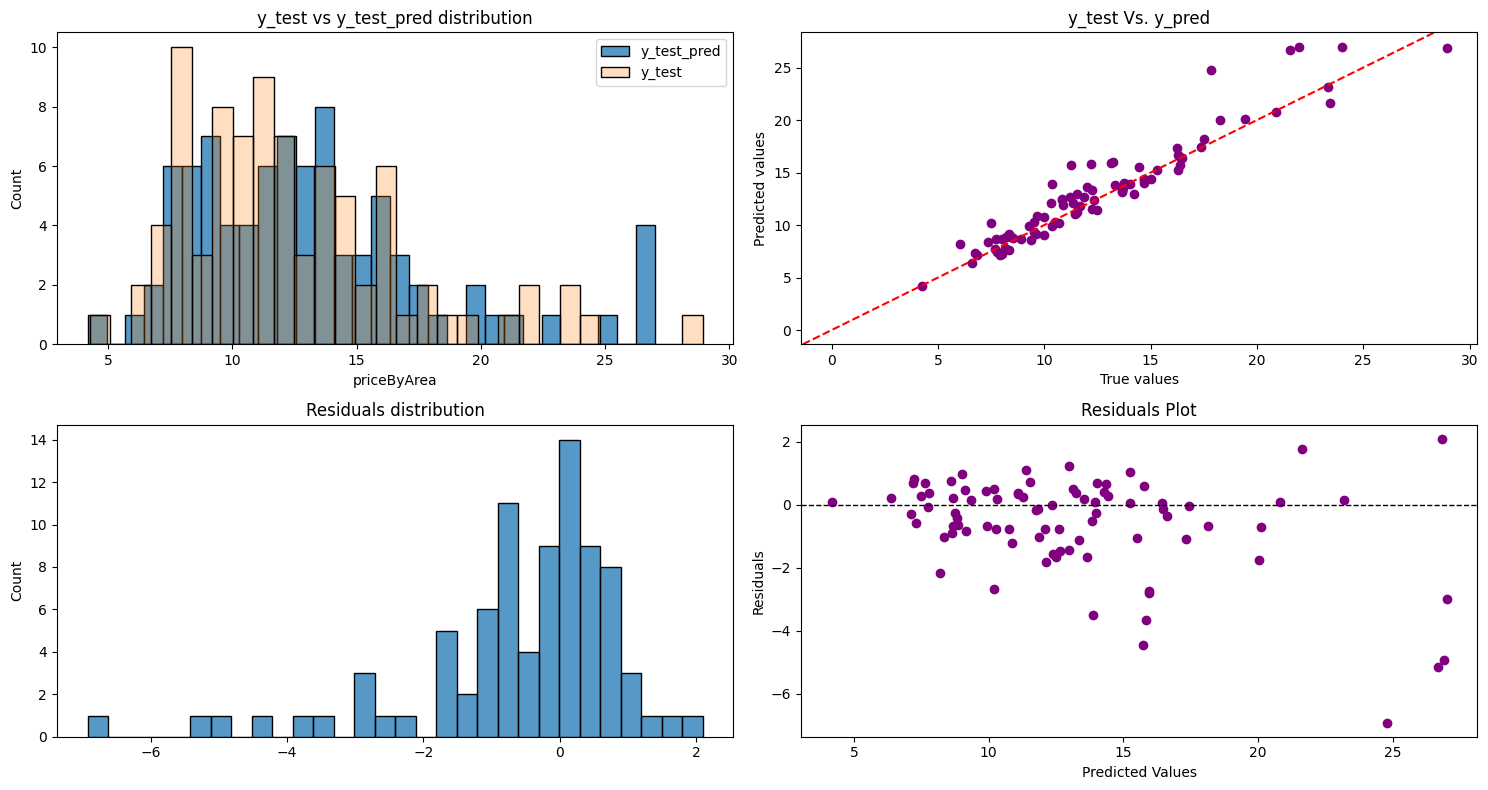

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.965802,0.696256,0.966816,28.270861,0.983268
test,0.870440,1.073494,2.729536,21.067777,1.652131


In [130]:
X = rent_df[["reciprocal_size","distance","bathrooms","exterior","hasPlan","parkingSpace_included_in_listing"]] 
y = rent_df["priceByArea"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - priceByArea | linear - numerical", model, X_train, y_train, X_test, y_test, tag=tag)

Recreating the value for price again:

In [97]:
warnings.filterwarnings("ignore")

# filtering the df to compare true values with predicted
y_test_df = rent_df.iloc[y_test.index]

# predict priceByArea and calculate price
y_test_df["priceByArea_pred"] = model.predict(X_test)

y_test_df["price_pred"] = y_test_df["priceByArea_pred"] * y_test_df["size"]

print(f"RMSE for price is {root_mean_squared_error(y_test_df['price'],y_test_df['price_pred'])} \n")

warnings.filterwarnings("default")

RMSE for price is 70.11776060703112 



Once more, the RMSE for price is very high, even slightly higher than before.

Plot the distributions, predictions Vs. the true values and the distribution of residuals for the calculated price from predictions.

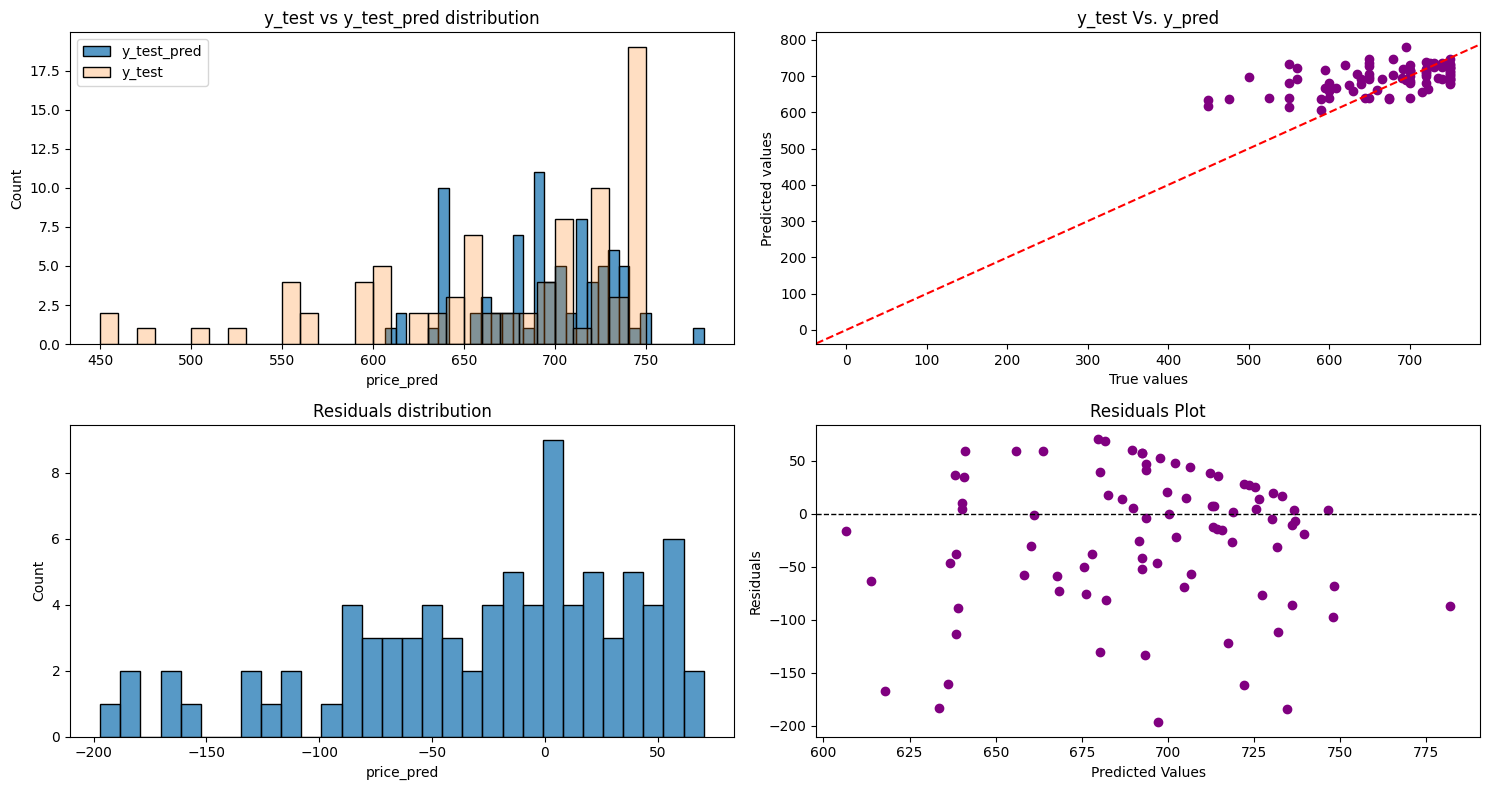

In [56]:
mes.plot_prediction_residuals(y_test_df["price"],y_test_df["price_pred"])

The model is still making the same mistakes as in the first experiment: Consistently over predicting. This raises the question of:
- The hypothesis of being able to predict price from priceByArea is not good.
- The model still needs more information to be able to predict strongly.

Therefore, it is necessary to perform to more evaluations:
1. Focus on predicting price, while also adding preprocessing for categorical features in terms of encoding and subsequent scaling to add more information to predict. A first alternative can be to use non-linear models on price, while adding more features.
2. Perform the same exploration to contrast if it is actually possible to add more information through priceByArea.

## 3.4 Experiment 4

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: Decision Tree Regressor, Random Forest Regressor, GradientBoosting
- Hyperparameter tuning: True
- Features: Numerical features - ["size","distance","bathrooms","exterior","hasPlan","parkingSpace_included_in_listing"]
- Preprocessing.
    - Missing: False
    - Outliers: False
    - Encoding: False
    - Scaling: False.
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.4.1 Data preparation

Data preparation steps are the same from the exploration notebook, and as such the cleaned data comes from there. [TO BE CHANGED BY A SCRIPT WITH THE STEPS]

### 3.4.2 Data preprocessing

Definition of the preprocessing pipeline, just a robust scaler is used, to preserve outliers information.

In [ ]:
preprocessing_pipeline = Pipeline([]) # empty instead of None, to not have to change the architecture

### 3.4.3 Feature engineering

None are necessary now.

### 3.4.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [139]:
models = {

    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150, 200],
            'regressor__max_depth': [10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 5, 10],
            'regressor__bootstrap': [True, False]
        }
    ),

    'DecisionTree': (
        DecisionTreeRegressor(),
        {
            'regressor__max_depth': [5, 10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 3, 5, 10],
            'regressor__max_leaf_nodes': [15, 20, 30, 40]
        }
    ),
    
    'GradientBoosting': (
        GradientBoostingRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [5, 7, 10, 20, 30, 40],
            'regressor__min_samples_split': [5, 10, 15, 20 ,30],
            'regressor__min_samples_leaf': [5, 10, 15],
            'regressor__subsample': [0.6, 0.8, 1.0],
        }
    )
}


### 3.4.5 Run experiment

Define X and y. Price must be excluded of course, as well as the original size feature. 

Perform train and test split. Define a bootstrapped repeated kfold cross validation to improve metric robustness. Optimize for minimal root_mean_squared error.

In [140]:
X = rent_df[["size","distance","bathrooms","exterior","hasPlan","parkingSpace_included_in_listing"]] 
y = rent_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")
best_model

c:\Users\Miguel\.virtualenvs\7._Rent_Madrid-EgbqKllV\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model_name': 'GradientBoosting',
 'pipeline': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('power_transform',
                                                   PowerTransformer(),
                                                   ['distance']),
                                                  ('scaler', RobustScaler(),
                                                   slice(0, None, None))])),
                 ('regressor',
                  GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                            min_samples_leaf=5,
                                            min_samples_split=30))]),
 'params': {'regressor__learning_rate': 0.05,
  'regressor__max_depth': 5,
  'regressor__min_samples_leaf': 5,
  'regressor__min_samples_split': 30,
  'regressor__n_estimators': 100,
  'regressor__subsample': 1.0},
 'score': np.float64(-46.07096767880043)}

The best model selected was RandomForest. Let's inspect its residuals, although its RMSE is already not looking too good.

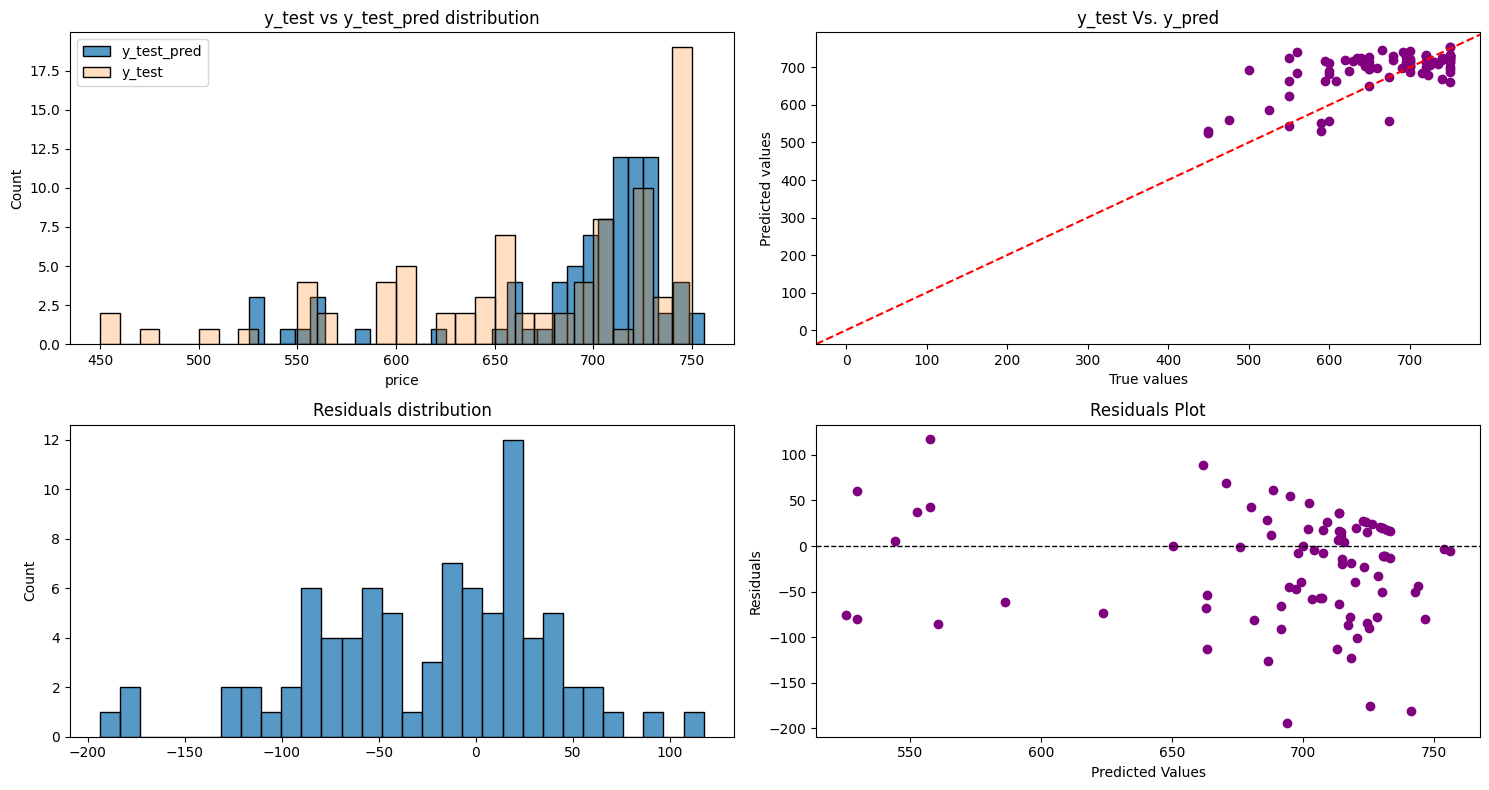

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.660445,23.032697,943.245967,2777.889314,30.712310
test,0.288795,48.966312,4124.566432,5799.404844,64.222787


In [141]:
tag = ("pipeline_preprocessing", "-")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - priceByArea | non-linear - numerical - ", model, X_train, y_train, X_test, y_test, tag=tag)

With 64 RMSE, this is to date the best model obtained, although very very far from perfect.

## 3.5 Experiment 5

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: Linear Regression, Lasso Regression.
- Rows filtered: priceByArea beyond 25 euros per squared meter are filtered out.
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped", "hasPlan"].
- Preprocessing.
    - Missing: False
    - Outliers: target capped at 25
    - Encoding: One-hot and target
    - Scaling: Robust Scaler. 
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.5.0 Data import from new preprocessing exploration

In [384]:
experiment_5_df = pd.read_csv("../datos/preprocessing/rent_df_preprocessing.csv")

### 3.5.1 Data preparation

In [385]:
experiment_5_df = experiment_5_df[experiment_5_df["priceByArea"] <= 25]
experiment_5_df.drop(columns=["municipality_grouped"])


,Unnamed: 0,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,p_area_property_grouped
0,1,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,False,False,True,False,3.0,flat or other
1,2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,False,False,0.0,flat or other
2,3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,False,False,2.0,flat or other
3,6,11,590.0,flat,70.0,True,3,2,56596,8.428571,False,False,False,False,False,unknown,flat or other
4,7,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,True,True,False,False,unknown,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,445,16,640.0,flat,69.0,True,2,1,29311,9.275362,False,False,False,True,True,2.0,flat or other
333,446,19,700.0,flat,54.0,True,1,1,11656,12.962963,True,True,True,True,False,1.0,flat or other
334,447,16,700.0,flat,59.0,True,1,1,7529,11.864407,False,False,False,True,True,4 or more,flat or other
335,448,11,700.0,flat,75.0,True,2,1,30359,9.333333,False,False,False,False,False,1.0,flat or other


In [386]:
experiment_5_df["p_area_property_grouped"] = experiment_5_df["p_area_property_grouped"].astype("category")

### 3.5.2 Data preprocessing

Encodings for categorical features.

In [387]:
# Define the categorical encoders
# one_hot_features = ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan"]
target_features = ["floor_grouped"]

In [388]:
column_transformer = ColumnTransformer(
    transformers=[
        # ('one_hot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),  
        ('target', ce.TargetEncoder(), target_features)
    ],
    remainder='passthrough'  
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('transformer', column_transformer),
    ('scaler', RobustScaler())
])

### 3.5.3 Feature engineering

To approximate the relationship between priceByArea and size variables to linearity, the reciprocal of size can be calculated as:

In [389]:
experiment_5_df["reciprocal_size"] = 1 / experiment_5_df["size"]

### 3.5.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [390]:
models = {
    'LinearRegression': (
        LinearRegression(), 
        {}
    ),

    'LassoRegression': (
        Lasso(max_iter=10000),
        {
            'regressor__alpha': [0.0001, 0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 10]
        }
    )
}


### 3.5.5 Run experiment

Just like before:

The best model selected was LassoRegression with params {'regressor__alpha': 0.01} and RMSE score of -1.0186098739965816


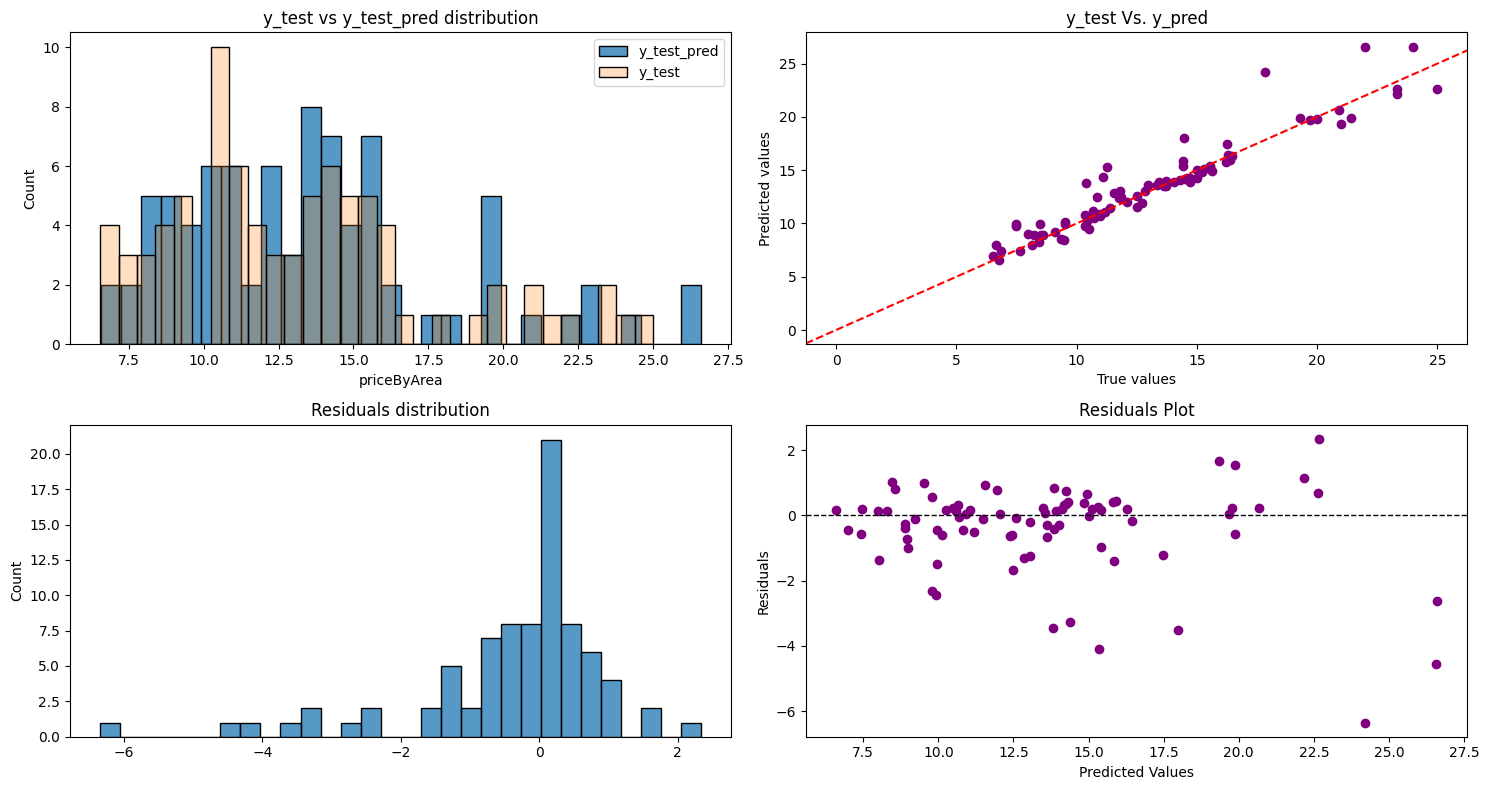

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.953374,0.751679,1.002731,21.506001,1.001365
test,0.891916,0.885069,2.055974,19.021961,1.433867


In [391]:
X = experiment_5_df[["reciprocal_size","distance","floor_grouped"]]

y = experiment_5_df["priceByArea"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "Onehot, target + RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - priceByArea | linear - numerical & categorical", model, X_train, y_train, X_test, y_test, tag=tag)

Recreating the value for price again:

In [392]:
warnings.filterwarnings("ignore")

# filtering the df to compare true values with predicted
y_test_df = rent_df.iloc[y_test.index]

# predict priceByArea and calculate price
y_test_df["priceByArea_pred"] = model.predict(X_test)

y_test_df["price_pred"] = y_test_df["priceByArea_pred"] * y_test_df["size"]

print(f"RMSE for price is {root_mean_squared_error(y_test_df['price'],y_test_df['price_pred'])} \n")

warnings.filterwarnings("default")

RMSE for price is 62.913177773869485 



The RMSE for price has only been slightly improved, which doesn't mean it could translate into a real improvement with real data.

Plot the distributions, predictions Vs. the true values and the distribution of residuals for the calculated price from predictions.

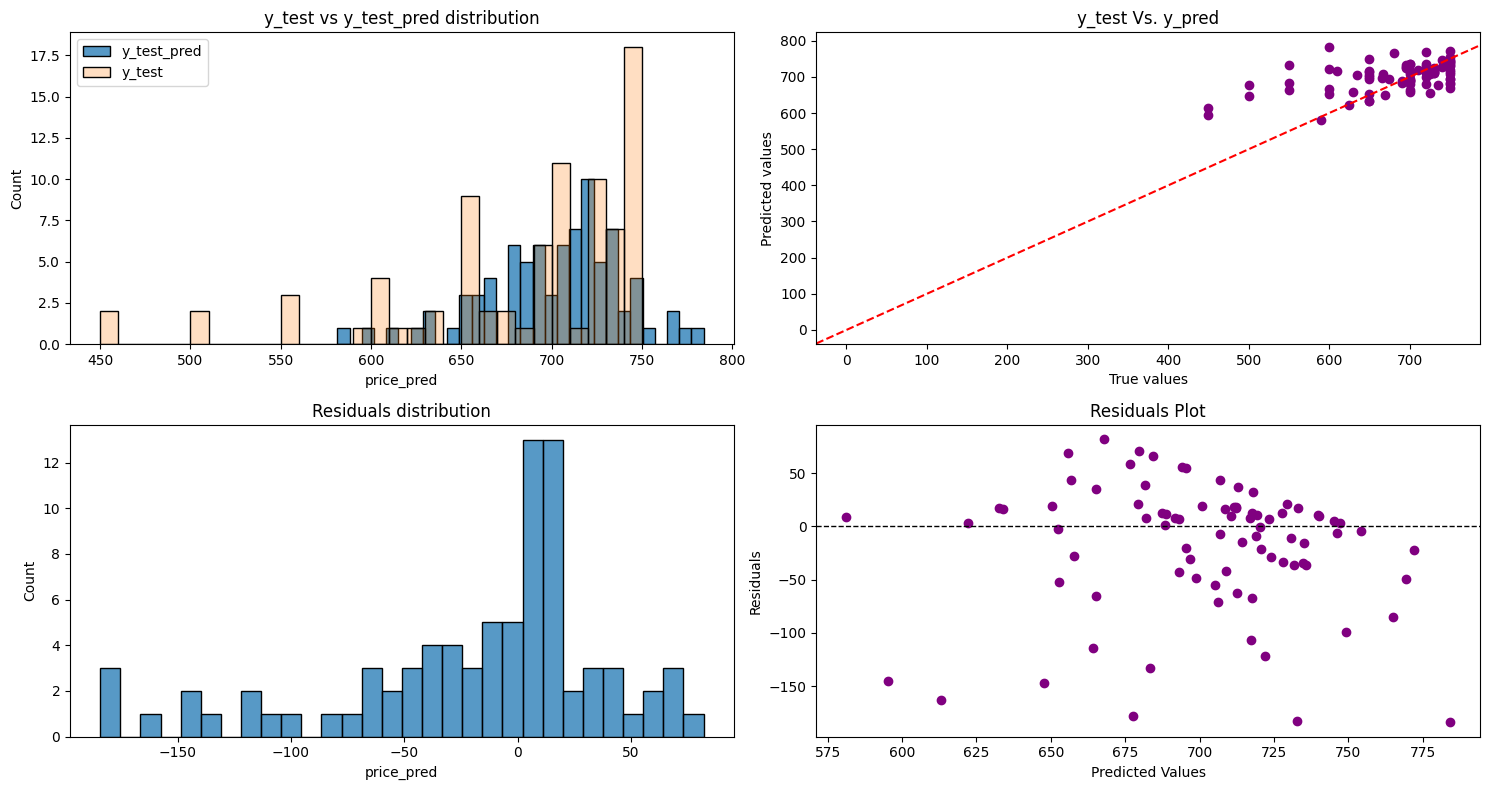

In [393]:
mes.plot_prediction_residuals(y_test_df["price"],y_test_df["price_pred"])

## 3.6 Experiment 6

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: DecisionTree, Random Forest, GradientBoosting
- Rows filtered: priceByArea beyond 25 euros per squared meter are filtered out.
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped", "hasPlan"].
- Preprocessing.
    - Missing: False
    - Outliers: target capped at 25
    - Encoding: One-hot and target
    - Scaling: Robust Scaler. 
- Feature Engineering:
    - reciprocal_size: 1 / size



### 3.6.0 Data import from new preprocessing exploration

In [328]:
experiment_5_df = pd.read_csv("../datos/preprocessing/rent_df_preprocessing.csv", index_col=0)

### 3.6.1 Data preparation

In [329]:
experiment_5_df = experiment_5_df[experiment_5_df["priceByArea"] <= 25]

### 3.6.2 Data preprocessing

Encodings for categorical features.

In [330]:
# Define the categorical encoders
one_hot_features = ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan"]
target_features = ["rooms", "parkingSpace_included_in_listing", "floor_grouped"]

In [331]:
column_transformer = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),  
        ('target', ce.TargetEncoder(), target_features)
    ],
    remainder='passthrough'  
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('transformer', column_transformer),
    ('scaler', RobustScaler())
])

### 3.6.3 Feature engineering

No feature engineering needed here.

### 3.6.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [333]:
models = {

    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150, 200],
            'regressor__max_depth': [10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 5, 10],
            'regressor__bootstrap': [True, False]
        }
    ),

    'DecisionTree': (
        DecisionTreeRegressor(),
        {
            'regressor__max_depth': [5, 10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 3, 5, 10],
            'regressor__max_leaf_nodes': [15, 20, 30, 40]
        }
    ),
    
    'GradientBoosting': (
        GradientBoostingRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [5, 7, 10, 20, 30, 40],
            'regressor__min_samples_split': [5, 10, 15, 20 ,30],
            'regressor__min_samples_leaf': [5, 10, 15],
            'regressor__subsample': [0.6, 0.8, 1.0],
        }
    )
}


### 3.6.5 Run experiment

Just like before:

c:\Users\Miguel\.virtualenvs\7._Rent_Madrid-EgbqKllV\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best model selected was GradientBoosting with params {'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 30, 'regressor__n_estimators': 50, 'regressor__subsample': 0.8} and RMSE score of -46.10577235509816


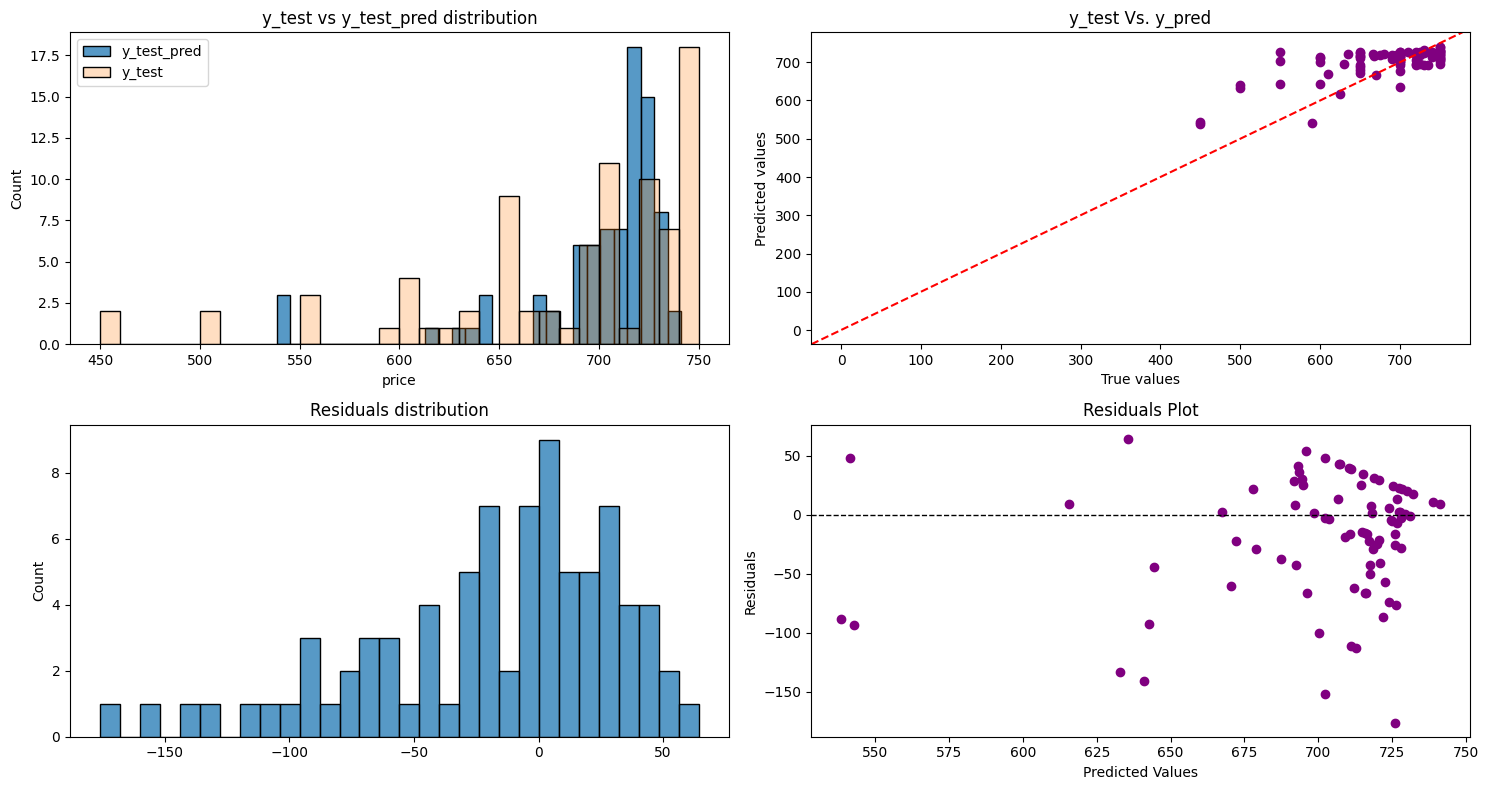

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.671717,25.101736,1112.876787,3389.990432,33.359808
test,0.395257,39.501613,2936.515505,4855.805487,54.189625


In [334]:
X = experiment_5_df[["size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped",
             "hasPlan"]]

y = experiment_5_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - price | non-linear - numerical & categorical", model, X_train, y_train, X_test, y_test, tag=tag)

## 3.7 Experiment 7

Variation of experiment 6, just for Madrid.

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: DecisionTree, Random Forest, GradientBoosting
- Rows filtered: priceByArea beyond 25 euros per squared meter are filtered out. Just rental units from Madrid are taken.
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped", "hasPlan"].
- Preprocessing.
    - Missing: False
    - Outliers: target capped at 25
    - Encoding: One-hot and target
    - Scaling: Robust Scaler. 
- Feature Engineering:
    - reciprocal_size: 1 / size



### 3.7.0 Data import from new preprocessing exploration

In [353]:
experiment_7_df = pd.read_csv("../datos/preprocessing/rent_df_preprocessing.csv", index_col=0)

### 3.7.1 Data preparation

In [354]:
experiment_7_df = experiment_7_df[experiment_7_df["priceByArea"] <= 25]
experiment_7_df = experiment_7_df[experiment_7_df["municipality_grouped"] == "Madrid"]
experiment_7_df.drop(columns=["municipality_grouped"],inplace=True)

### 3.7.2 Data preprocessing

Encodings for categorical features.

In [355]:
# Define the categorical encoders
one_hot_features = ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan"]
target_features = ["rooms", "parkingSpace_included_in_listing", "floor_grouped"]

In [356]:
column_transformer = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),  
        ('target', ce.TargetEncoder(), target_features)
    ],
    remainder='passthrough'  
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('transformer', column_transformer)
])

### 3.7.3 Feature engineering

No feature engineering needed here.

### 3.7.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [357]:
models = {

    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150, 200],
            'regressor__max_depth': [10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 5, 10],
            'regressor__bootstrap': [True, False]
        }
    ),

    'DecisionTree': (
        DecisionTreeRegressor(),
        {
            'regressor__max_depth': [5, 10, 15, 20, 25],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 3, 5, 10],
            'regressor__max_leaf_nodes': [15, 20, 30, 40]
        })
#     ),
    
#     'GradientBoosting': (
#         GradientBoostingRegressor(),
#         {
#             'regressor__n_estimators': [50, 100, 150],
#             'regressor__learning_rate': [0.01, 0.05, 0.1],
#             'regressor__max_depth': [5, 7, 10, 20, 30, 40],
#             'regressor__min_samples_split': [5, 10, 15, 20 ,30],
#             'regressor__min_samples_leaf': [5, 10, 15],
#             'regressor__subsample': [0.6, 0.8, 1.0],
#         }
#     )
}


### 3.7.5 Run experiment

Just like before:

c:\Users\Miguel\.virtualenvs\7._Rent_Madrid-EgbqKllV\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best model selected was RandomForest with params {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 15, 'regressor__n_estimators': 200} and RMSE score of -42.95973253439896


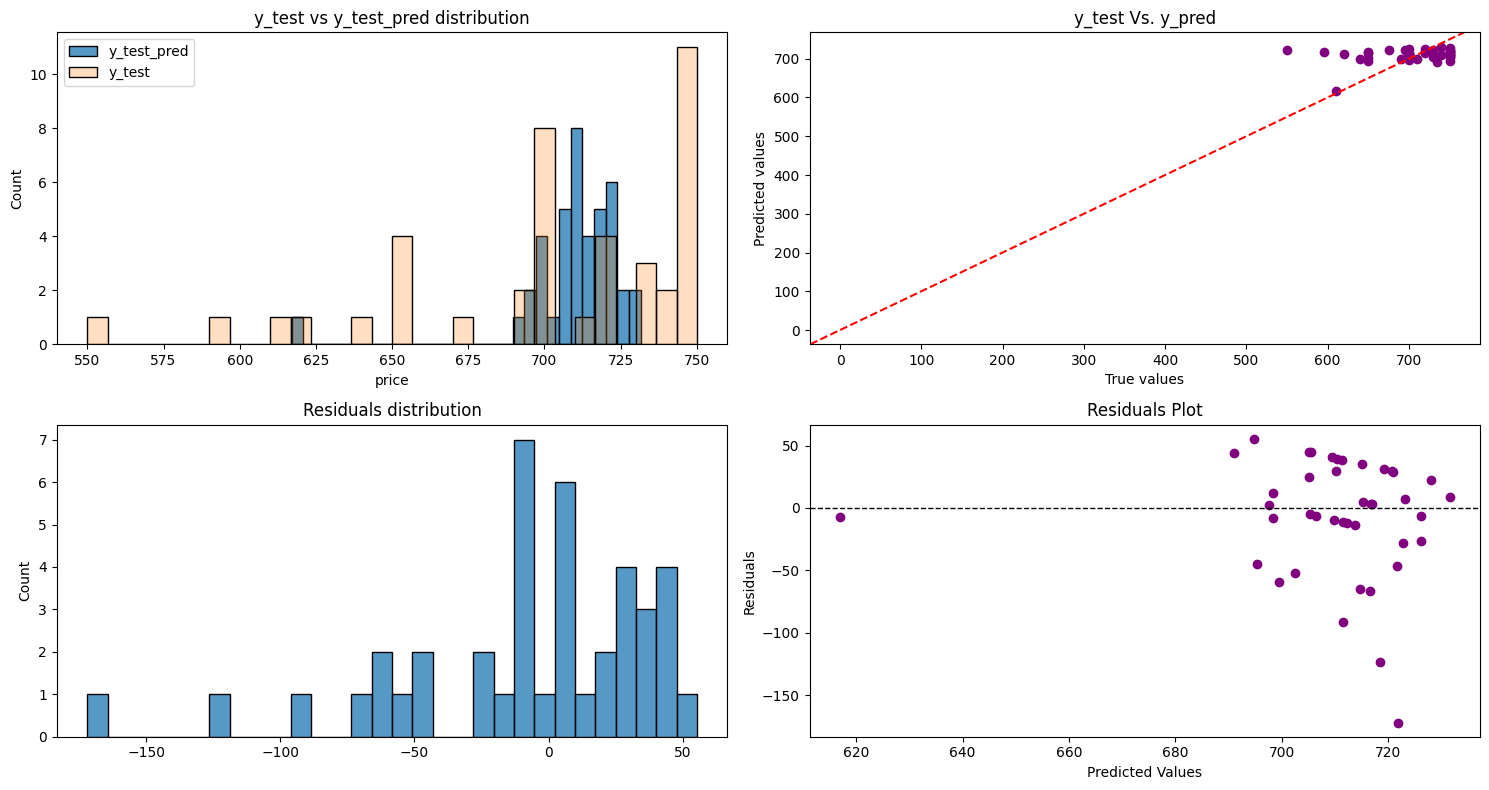

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.489022,26.194086,1233.501085,2413.999931,35.121234
test,0.032505,34.282097,2303.167457,2380.547293,47.991327


In [358]:
X = experiment_7_df[["size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped",
             "hasPlan"]]

y = experiment_7_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - price | non-linear - numerical & categorical", model, X_train, y_train, X_test, y_test, tag=tag)

## 3.8 Experiment 8

Variation of experiment 6, further optimization of Gradient Boosting.

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: GradientBoosting
- Rows filtered: False
- Hyperparameter tuning: True
- Features: Numerical features - ["reciprocal_size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped", "hasPlan"].
- Preprocessing.
    - Missing: False
    - Outliers: target capped at 25
    - Encoding: One-hot and target
    - Scaling: Robust Scaler. 



### 3.8.0 Data import from new preprocessing exploration

In [394]:
experiment_8_df = pd.read_csv("../datos/preprocessing/rent_df_preprocessing.csv", index_col=0)

### 3.8.1 Data preparation

None.

### 3.8.2 Data preprocessing

Encodings for categorical features.

In [395]:
# Define the categorical encoders
one_hot_features = ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan"]
target_features = ["rooms", "parkingSpace_included_in_listing", "floor_grouped"]

In [396]:
column_transformer = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),  
        ('target', ce.TargetEncoder(), target_features)
    ],
    remainder='passthrough'  
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('transformer', column_transformer)
])

### 3.8.3 Feature engineering

No feature engineering needed here.

### 3.8.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [ ]:
models = {
   
    'GradientBoosting': (
        GradientBoostingRegressor(),
        {
            'regressor__n_estimators': [25,30,40,50,60,70],
            'regressor__learning_rate': [0.03,0.04, 0.1],
            'regressor__max_depth': [6,7,8],
            'regressor__min_samples_split': [30,40,50],
            'regressor__min_samples_leaf': [3,5,10],
            'regressor__subsample': [0.7,0.8,0.9],
        }
    )
}


### 3.8.5 Run experiment

Just like before:

The best model selected was GradientBoosting with params {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 40, 'regressor__n_estimators': 25, 'regressor__subsample': 0.8} and RMSE score of -45.46656992365853


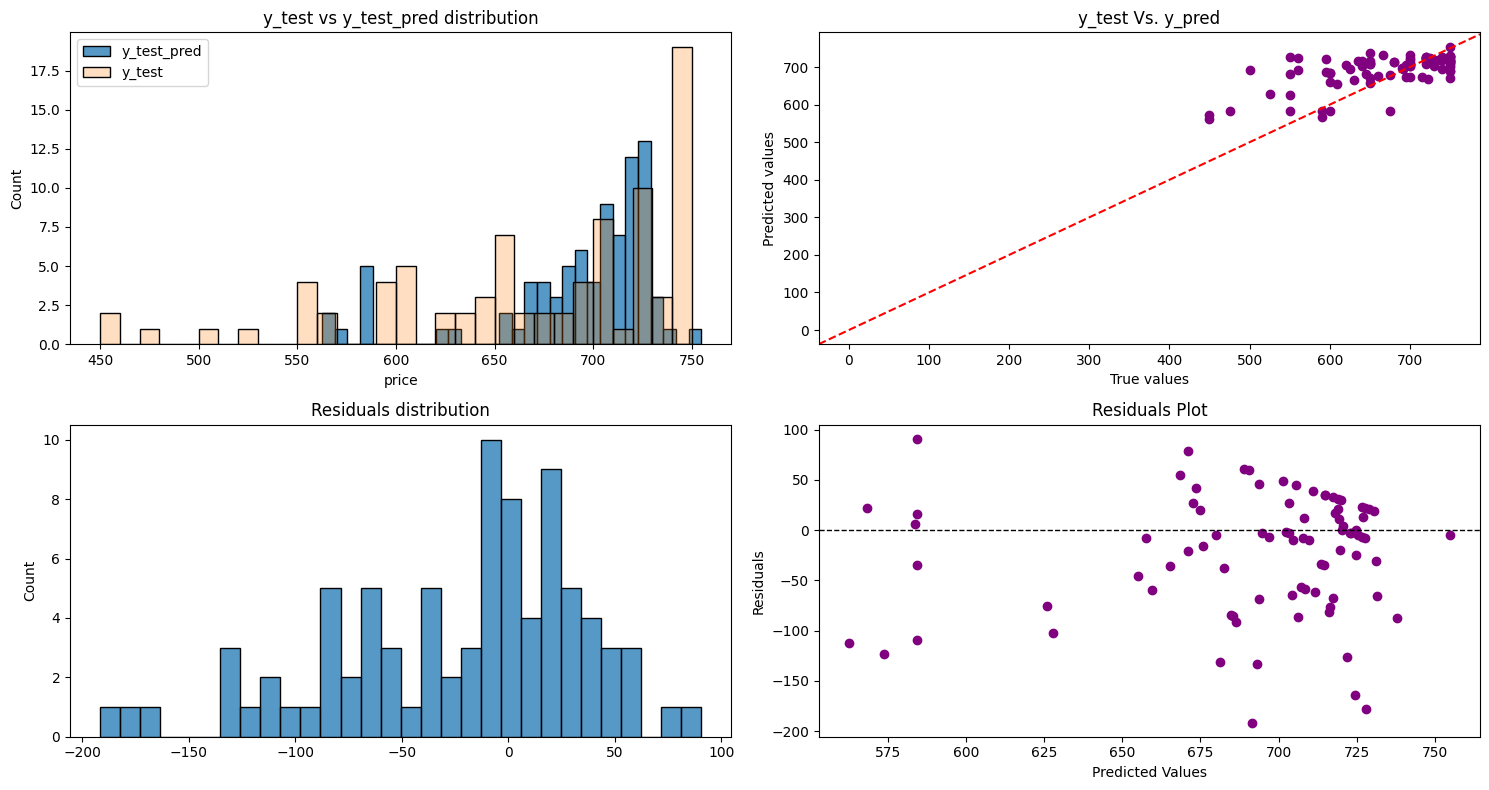

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.516538,27.453726,1343.004009,2777.889314,36.647019
test,0.306908,46.752740,4019.521921,5799.404844,63.399700


In [398]:
X = experiment_8_df[["size","distance","bathrooms","exterior","parkingSpace_included_in_listing",
             "rooms", "floor_grouped", "p_area_property_grouped",
             "hasPlan"]]

y = experiment_8_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - price | non-linear - numerical & categorical", model, X_train, y_train, X_test, y_test, tag=tag)

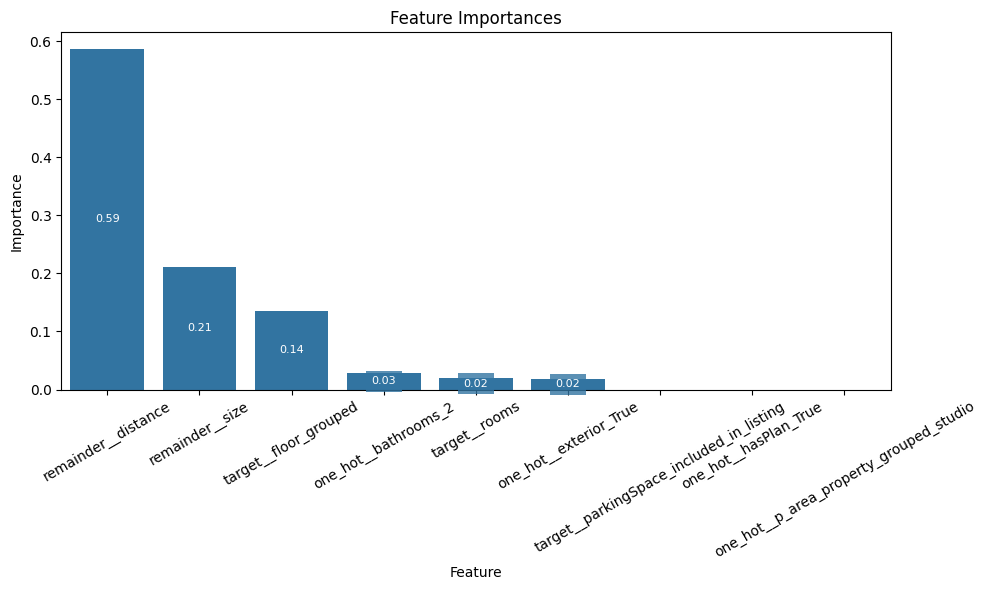

In [399]:
feature_importances = model.named_steps["regressor"].feature_importances_
feature_names = model.named_steps["transformer"].get_feature_names_out()

sorted_indices = np.argsort(feature_importances)[::-1]

df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_indices],
    'Importance': feature_importances[sorted_indices]
})

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')

ax = sns.barplot(x='Feature', y='Importance', data=df)
dvs.plot_bar_labels(ax)
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


2 observations:
- The model consistently overpredicts. It is prudent to remove univariate outliers below 550 to check how predictions rearrange.
- The most important features are distance, size and floor_grouped, let's try with just those.

## 3.9 Experiment 9

Variation of experiment 6, further optimization of Gradient Boosting.

Conditions for the experiment.
- Target: priceByArea
- Models to evaluate: GradientBoosting
- Rows filtered: price below 550 euros are filtered out.
- Hyperparameter tuning: True
- Features: Numerical features - ["size","distance","floor_grouped"].
- Preprocessing.
    - Missing: False
    - Outliers: target capped at 25
    - Encoding: One-hot and target
    - Scaling: Robust Scaler. 



### 3.9.0 Data import from new preprocessing exploration

In [427]:
experiment_8_df = pd.read_csv("../datos/preprocessing/rent_df_preprocessing.csv", index_col=0)

### 3.9.1 Data preparation

In [428]:
experiment_8_df = experiment_8_df[experiment_8_df["priceByArea"] <= 25]

### 3.9.2 Data preprocessing

Encodings for categorical features.

In [435]:
# Define the categorical encoders
one_hot_features = ["exterior", "bathrooms","municipality_grouped"]
target_features = ["rooms" ,"floor_grouped"]

In [436]:
column_transformer = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),  
        ('target', ce.TargetEncoder(), target_features)
    ],
    remainder='passthrough'  
)

# Combine into a pipeline
preprocessing_pipeline = Pipeline([
    ('transformer', column_transformer)
])

### 3.9.3 Feature engineering

No feature engineering needed here.

### 3.9.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [437]:
models = {
   
    'GradientBoosting': (
        GradientBoostingRegressor(),
        {'regressor__learning_rate': [0.04], 
         'regressor__max_depth': [8], 
         'regressor__min_samples_leaf': [5], 
         'regressor__min_samples_split': [50], 
         'regressor__n_estimators': [70], 
         'regressor__subsample': [0.9]}
    )
}


### 3.9.5 Run experiment

Just like before:

In [438]:
experiment_8_df.columns

Index(['numPhotos', 'price', 'propertyType', 'size', 'exterior', 'rooms',
       'bathrooms', 'distance', 'priceByArea', 'hasPlan', 'has360', 'hasVideo',
       'hasLift', 'parkingSpace_included_in_listing', 'floor_grouped',
       'municipality_grouped', 'p_area_property_grouped'],
      dtype='object')

The best model selected was GradientBoosting with params {'regressor__learning_rate': 0.04, 'regressor__max_depth': 8, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 50, 'regressor__n_estimators': 70, 'regressor__subsample': 0.9} and RMSE score of -45.62442327069021


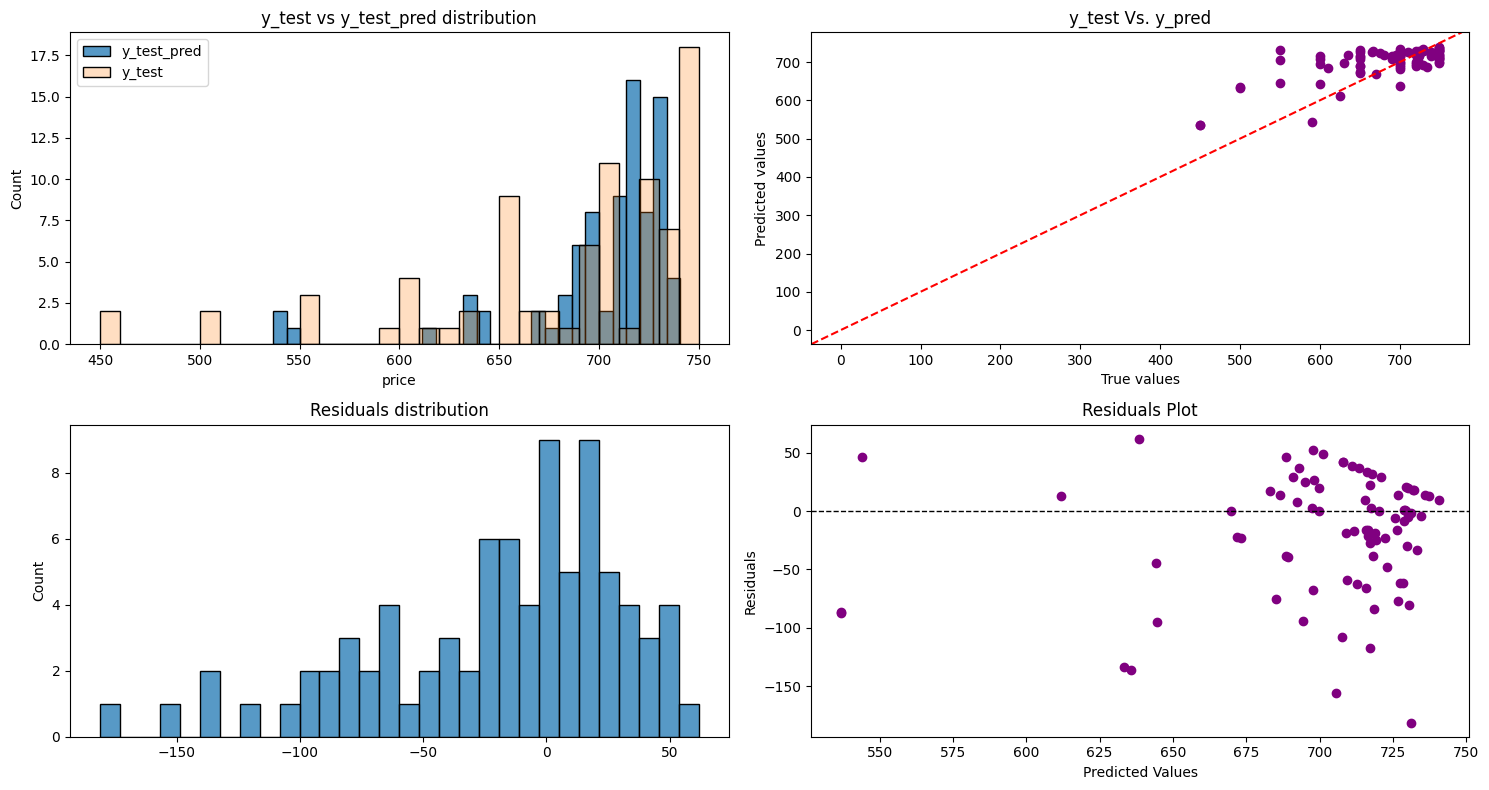

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.668708,25.135694,1123.077912,3389.990432,33.512355
test,0.388419,39.696848,2969.720747,4855.805487,54.495144


In [443]:
X = experiment_8_df[["size","distance","floor_grouped","exterior","bathrooms","rooms","municipality_grouped"]]

y = experiment_8_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=3, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"

verbosity = False

best_model = mes.run_pipelines(X_train, y_train, preprocessing_pipeline, models, cross_val, score, verbosity,search_method="grid")

print(f"The best model selected was {best_model['model_name']} with params {best_model['params']} and RMSE score of {best_model['score']}")

tag = ("pipeline_preprocessing", "RobustScaler")

model = best_model["pipeline"]

mes.test_evaluate_model("Test evaluation - price | non-linear - numerical & categorical", model, X_train, y_train, X_test, y_test, tag=tag)

Although the error is smaller than in the previous run, the r-squared is negligible. This is an indication of overfitting, but actually it does not overfit any more than the previous model, as the truth is that no model developed has really fitted to the test distribution.

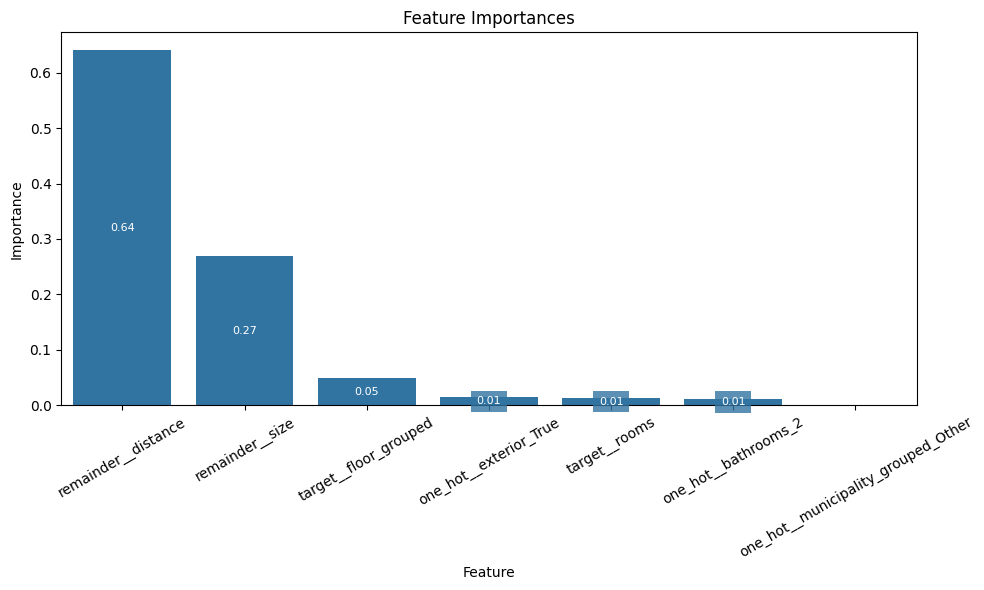

In [444]:
feature_importances = model.named_steps["regressor"].feature_importances_
feature_names = model.named_steps["transformer"].get_feature_names_out()

sorted_indices = np.argsort(feature_importances)[::-1]

df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_indices],
    'Importance': feature_importances[sorted_indices]
})

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')

ax = sns.barplot(x='Feature', y='Importance', data=df)
dvs.plot_bar_labels(ax)
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()
